In [1]:

# pip install -U numpy pandas torch matplotlib
# pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"

# source venv312/bin/activate


In [2]:
import sys
from pathlib import Path

# Point to the project root (parent of "models" and "utils")
project_root = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print("Project root:", project_root)

Project root: /Users/jan/Documents/working papers/project 1


In [3]:
import os
import sys
import math
import warnings
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd

import torch

# Granite TSFM imports
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.time_series_forecasting_pipeline import TimeSeriesForecastingPipeline

from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

warnings.filterwarnings("ignore")

def pick_device():
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

DEVICE = pick_device()
DEVICE


device(type='mps')

In [4]:
# config
CSV_PATH = str(Path("/Users/jan/Documents/working papers/project 1/data/btc_1h_test.csv"))
ID_COL = "series"
TIME_COL = "timestamp"
TARGET_COL = "close"
CONST_ID = "BTCUSD"

ROLL_STEP   = 1    # stride of the rolling window 
H_TARGET    = 1   # which horizon to score (1 = t+1, 2 = t+2, ...)

FREQ = "1H"                 # 1-hour data
CONTEXT_LENGTH = 512       # rolling context
PREDICTION_LENGTH = 96     # model emits 96 steps
PREDICTION_LENGTH = max(PREDICTION_LENGTH, H_TARGET)  # ensure we predict at least up to H_TARGET

# switch r2 -> r1 if needed
MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"

# output file for predictions
OUT_PRED_CSV = "ttm_btc_rolling_preds.csv"


In [5]:
# data loading and preprocessing
df = pd.read_csv(CSV_PATH)

if TIME_COL not in df.columns or TARGET_COL not in df.columns:
    raise ValueError(f"CSV must include '{TIME_COL}' and '{TARGET_COL}' columns. Found: {list(df.columns)}")

df[TIME_COL] = pd.to_datetime(df[TIME_COL], utc=True, errors="coerce")
df = df.dropna(subset=[TIME_COL, TARGET_COL]).sort_values(TIME_COL).reset_index(drop=True)


df[ID_COL] = CONST_ID

df = df[[TIME_COL, ID_COL, TARGET_COL]].copy()

print(df.head(3))
print(df.tail(3))
print("Rows:", len(df))


                  timestamp  series     close
0 2018-01-01 00:00:00+00:00  BTCUSD  13999.14
1 2018-01-01 00:15:00+00:00  BTCUSD  13886.89
2 2018-01-01 00:30:00+00:00  BTCUSD  13920.00
                     timestamp  series    close
9997 2018-04-15 03:15:00+00:00  BTCUSD  8022.00
9998 2018-04-15 03:30:00+00:00  BTCUSD  7992.12
9999 2018-04-15 03:45:00+00:00  BTCUSD  8000.41
Rows: 10000


In [6]:
# build preprocessor, model, pipeline
column_specifiers = {
    "timestamp_column": TIME_COL,
    "id_columns": [ID_COL],
    "target_columns": [TARGET_COL],  # list even for one target
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    scaling=False,            # zero-shot: no tsp.train needed
    encode_categorical=False,
)

model = get_model(
    model_path=MODEL_PATH,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    freq=None,
).to(DEVICE)

pipe = TimeSeriesForecastingPipeline(
    model=model,
    feature_extractor=tsp,   
    device=DEVICE,
    batch_size=32,
)


INFO:p-92713:t-8556028096:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-92713:t-8556028096:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-92713:t-8556028096:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
Device set to use mps


In [7]:
def _extract_h_step(forecast_df: pd.DataFrame, h_target: int) -> float:
    df = forecast_df.copy()

    for hcol in ("horizon", "step", "k"):
        if hcol in df.columns:
            df = df[df[hcol].astype(int) == h_target]
            break


    if len(df) > 1 and any(c in df.columns for c in ("horizon","step","k")):
        df = df.sort_values(by=[c for c in ("horizon","step","k") if c in df.columns]).head(1)

    # Preferred scalar point columns
    for pcol in ("point","mean","yhat","prediction","pred"):
        if pcol in df.columns and not df.empty:
            val = df.iloc[0][pcol]
            # Vector case: select the (h_target-1)-th element
            if isinstance(val, (list, tuple, np.ndarray)):
                return float(val[h_target-1])
            return float(val)

    # Quantiles as fallback (prefer median)
    for qcol in ("p50","median","q50","q_0.5"):
        if qcol in df.columns and not df.empty:
            val = df.iloc[0][qcol]
            if isinstance(val, (list, tuple, np.ndarray)):
                return float(val[h_target-1])
            return float(val)

    # Vector-in-cell across some other column
    for col in df.columns:
        val = df.iloc[0][col]
        if isinstance(val, (list, tuple, np.ndarray)) and len(val) >= h_target:
            return float(val[h_target-1])

    raise ValueError(f"Could not extract horizon {h_target}; seen columns: {list(forecast_df.columns)}")

In [8]:
# ==== Rolling forecast ====

series_vals = df["close"].to_numpy(float)
times       = df["timestamp"].to_numpy()

min_len = CONTEXT_LENGTH + H_TARGET
if len(series_vals) < min_len:
    raise ValueError(f"Need at least {min_len} points, have {len(series_vals)}.")

y_true, y_pred, t_stamps = [], [], []

start = CONTEXT_LENGTH
stop  = len(series_vals) - H_TARGET + 1  # inclusive end for i + H_TARGET

for i in range(start, stop, ROLL_STEP):
    ctx_df = df.iloc[i - CONTEXT_LENGTH : i][["timestamp","series","close"]].copy()
    forecast_df = pipe(ctx_df)

    pred_i = _extract_h_step(forecast_df, h_target=H_TARGET)

    y_true.append(series_vals[i + H_TARGET - 1])   # ground-truth at t+H
    y_pred.append(pred_i)
    t_stamps.append(times[i + H_TARGET - 1])

    if i % 200 == 0:
        print(f"Processed i={i}/{stop-1}")

pred_df = pd.DataFrame({"timestamp": t_stamps, "y_true": y_true, "y_pred": y_pred})
display(pred_df.head())


Processed i=600/9999
Processed i=800/9999
Processed i=1000/9999
Processed i=1200/9999
Processed i=1400/9999
Processed i=1600/9999
Processed i=1800/9999
Processed i=2000/9999
Processed i=2200/9999
Processed i=2400/9999
Processed i=2600/9999
Processed i=2800/9999
Processed i=3000/9999
Processed i=3200/9999
Processed i=3400/9999
Processed i=3600/9999
Processed i=3800/9999
Processed i=4000/9999
Processed i=4200/9999
Processed i=4400/9999
Processed i=4600/9999
Processed i=4800/9999
Processed i=5000/9999
Processed i=5200/9999
Processed i=5400/9999
Processed i=5600/9999
Processed i=5800/9999
Processed i=6000/9999
Processed i=6200/9999
Processed i=6400/9999
Processed i=6600/9999
Processed i=6800/9999
Processed i=7000/9999
Processed i=7200/9999
Processed i=7400/9999
Processed i=7600/9999
Processed i=7800/9999
Processed i=8000/9999
Processed i=8200/9999
Processed i=8400/9999
Processed i=8600/9999
Processed i=8800/9999
Processed i=9000/9999
Processed i=9200/9999
Processed i=9400/9999
Processed i=

,timestamp,y_true,y_pred
0,2018-01-06 08:00:00+00:00,16669.48,16582.218750
1,2018-01-06 08:15:00+00:00,16710.36,16624.521484
2,2018-01-06 08:30:00+00:00,16634.19,16651.185547
3,2018-01-06 08:45:00+00:00,16547.81,16599.222656
4,2018-01-06 09:00:00+00:00,16462.05,16533.042969


In [9]:
# save predictions
pred_df = pd.DataFrame({
    "timestamp": pd.to_datetime(t_stamps),         
    "y_true": np.asarray(y_true, dtype=np.float32), 
    "y_pred": np.asarray(y_pred, dtype=np.float32),
})
pred_df.to_csv(OUT_PRED_CSV, index=False)
print(f"Saved predictions to: {OUT_PRED_CSV} (rows={len(pred_df)})")

Saved predictions to: ttm_btc_rolling_preds.csv (rows=9488)


In [10]:
import pandas as pd
from utils.metrics import evaluate_forecast

df = pd.read_csv("ttm_btc_rolling_preds.csv", parse_dates=["timestamp"])

res = evaluate_forecast(
    df["y_true"], df["y_pred"], df["timestamp"],
    starting_capital=100_000, threshold=0.005, fee_rate=0.001
)

eq_end_no = float(res["equity_no_tc"].iloc[-1])
eq_end_tc = float(res["equity_tc"].iloc[-1])
cum_fee   = float(res["cum_fee"].iloc[-1])

print(f"Final equity (no fees):   {eq_end_no:,.2f}")
print(f"Final equity (with fees): {eq_end_tc:,.2f}")
print(f"Total fees paid:          {cum_fee:,.2f}")

# metrics
for k in ["arc", "asd", "mdd", "ir_star", "ir_starstar"]:
    v = res[k]
    print(f"{k}: {v:.6f}" if isinstance(v, float) else f"{k}: {v}")

Final equity (no fees):   97,336.58
Final equity (with fees): 749.90
Total fees paid:          100,615.17
arc: -1.000000
asd: 1.035889
mdd: 0.992553
ir_star: -0.965355
ir_starstar: -0.972598


In [11]:

df = df.copy()
df["equity"]    = res["equity_no_tc"].to_numpy(float)
df["equity_tc"] = res["equity_tc"].to_numpy(float)
df["fee"]       = res["fee"].to_numpy(float)
df["cum_fee"]   = res["cum_fee"].to_numpy(float)


print(df[["timestamp","y_true","y_pred","equity","equity_tc","cum_fee"]].head(3))
print(df[["timestamp","y_true","y_pred","equity","equity_tc","cum_fee"]].tail(3))

                  timestamp    y_true     y_pred         equity  \
0 2018-01-06 08:00:00+00:00  16669.48  16582.219  100000.000000   
1 2018-01-06 08:15:00+00:00  16710.36  16624.521   99754.761396   
2 2018-01-06 08:30:00+00:00  16634.19  16651.186  100209.468547   

       equity_tc  cum_fee  
0  100000.000000      0.0  
1   99655.006635    100.0  
2  100109.259078    100.0  
                     timestamp   y_true     y_pred        equity   equity_tc  \
9485 2018-04-15 03:15:00+00:00  8022.00  8062.4326  97599.250198  752.678637   
9486 2018-04-15 03:30:00+00:00  7992.12  8048.8574  97235.716716  749.125217   
9487 2018-04-15 03:45:00+00:00  8000.41  8012.9330  97336.576574  749.902264   

            cum_fee  
9485  100614.421185  
9486  100615.173863  
9487  100615.173863  


(<Figure size 1200x800 with 2 Axes>,
 (<Axes: title={'center': 'TTM zero-shot BTC 1h'}, ylabel='Price'>,
  <Axes: title={'center': 'Equity (with fees) vs B&H'}, xlabel='Time', ylabel='Equity'>))

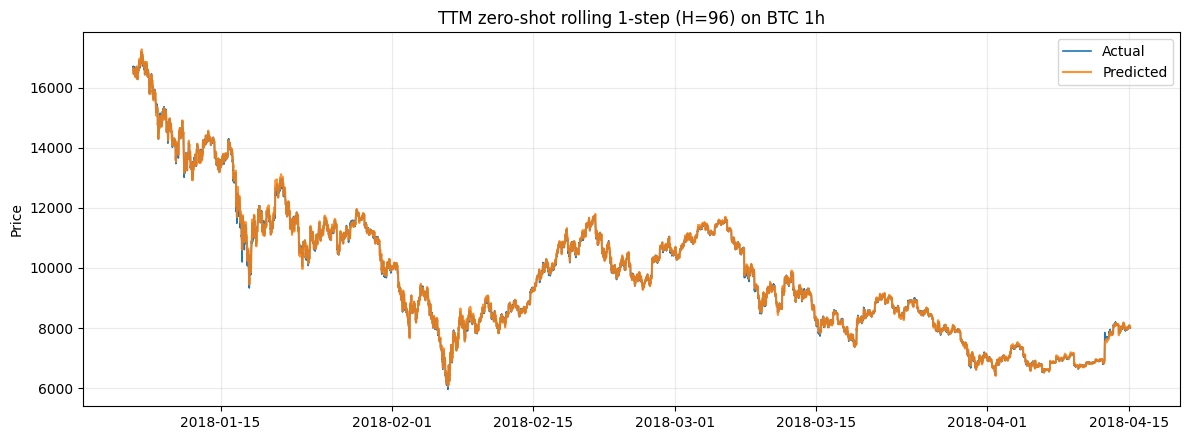

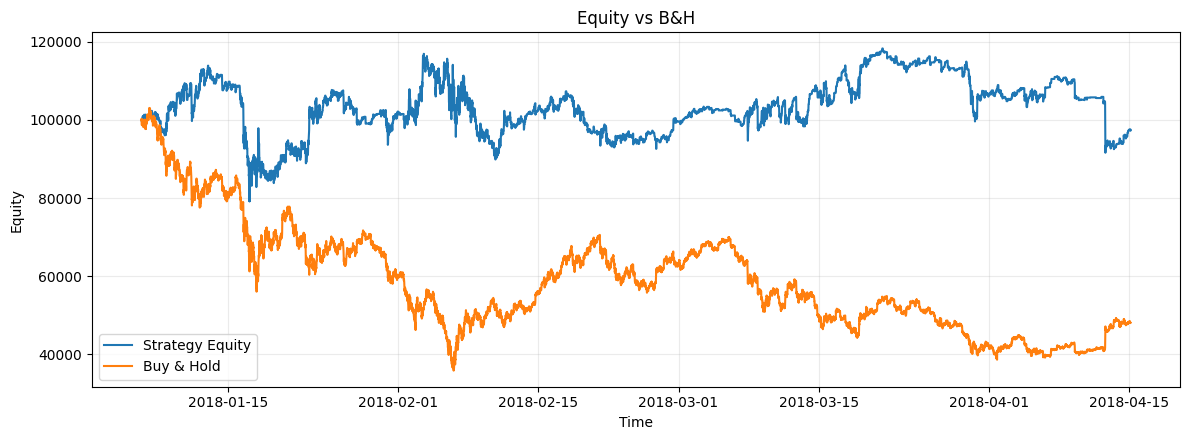

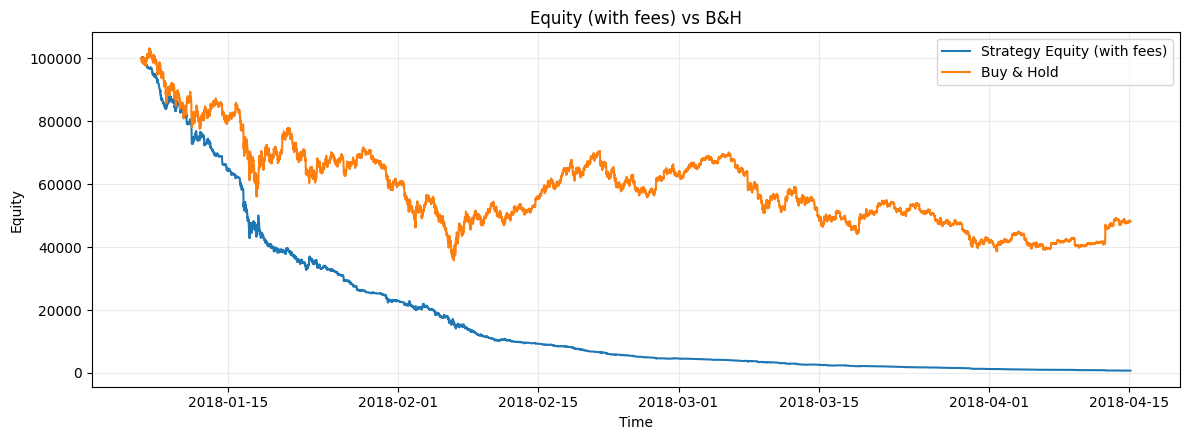

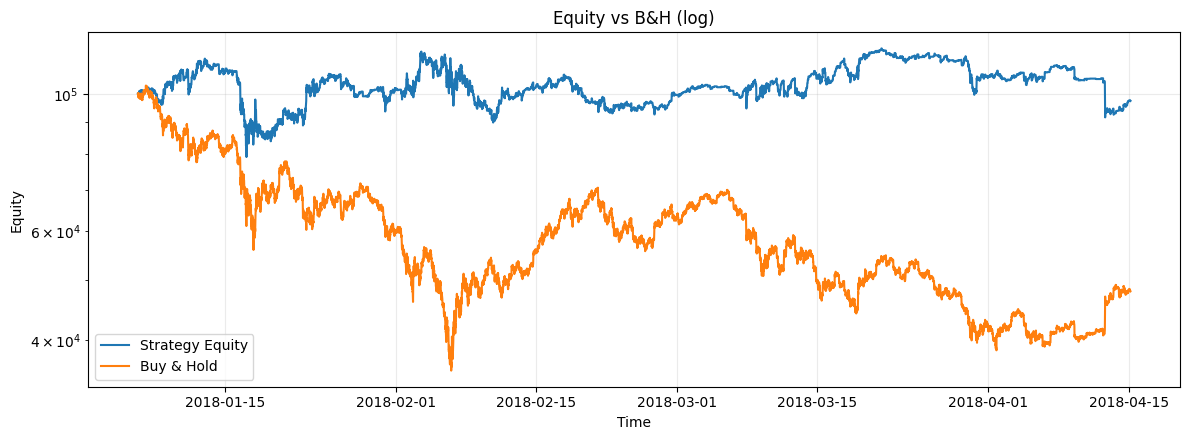

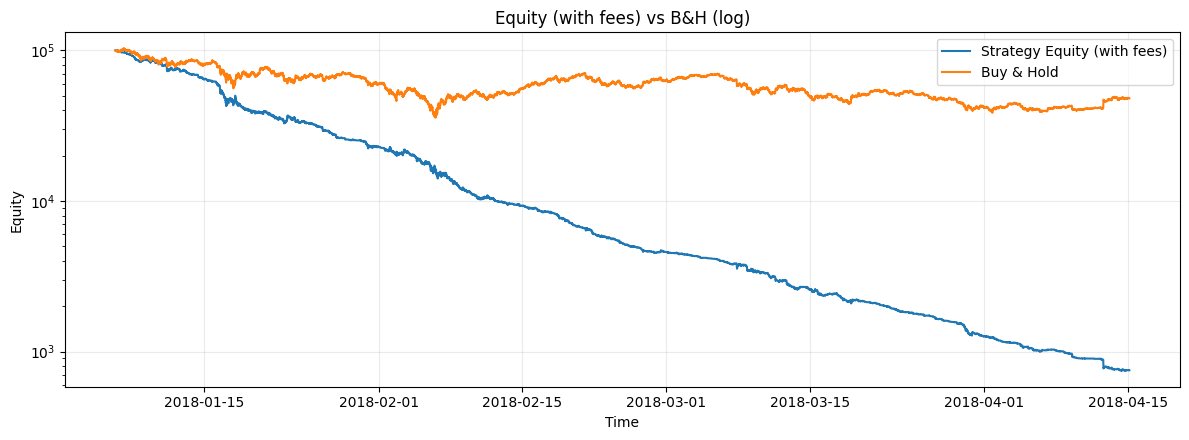

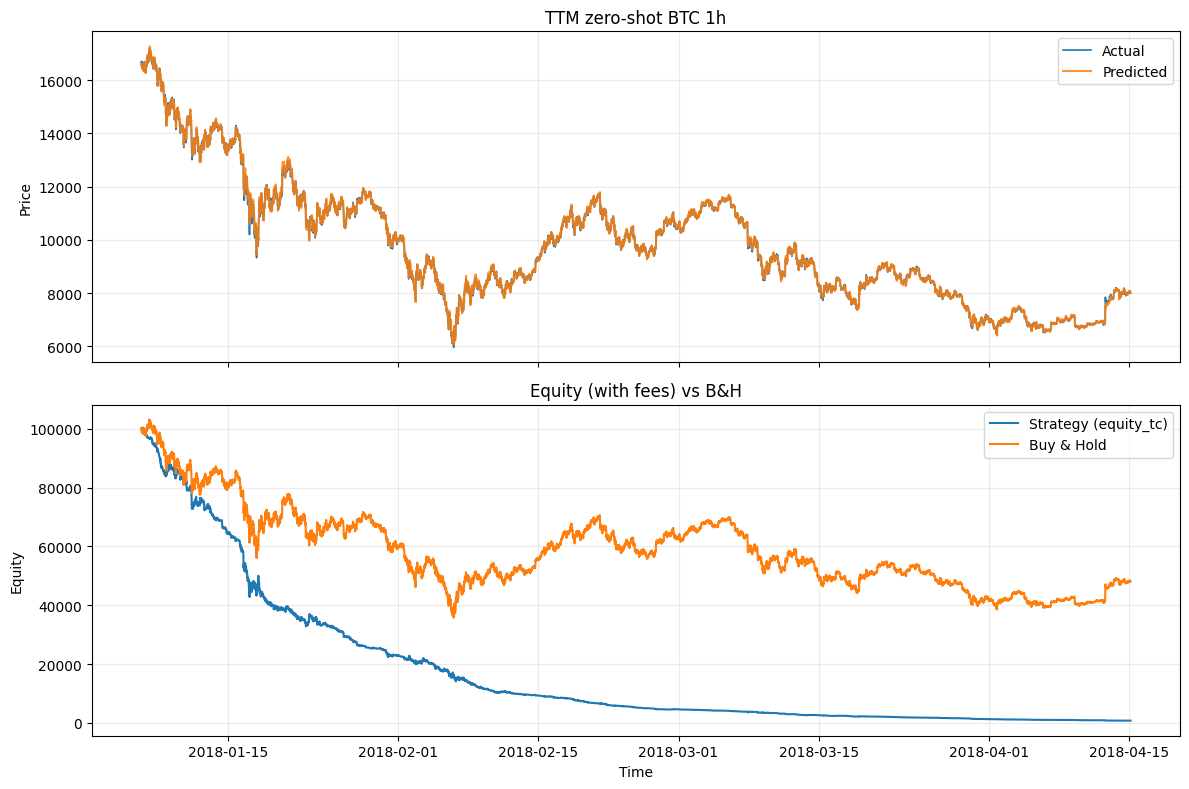

In [12]:
from utils.plotting import (
    plot_price_actual_vs_pred,
    plot_equity_no_tc_vs_bh,
    plot_equity_tc_vs_bh,
    plot_equity_no_tc_vs_bh_log,
    plot_equity_tc_vs_bh_log,
    plot_price_and_equity_panel,
)

plot_price_actual_vs_pred(df, title="TTM zero-shot rolling 1-step (H=96) on BTC 1h")
plot_equity_no_tc_vs_bh(df, title="Equity vs B&H")
plot_equity_tc_vs_bh(df, title="Equity (with fees) vs B&H")
plot_equity_no_tc_vs_bh_log(df, title="Equity vs B&H (log)")
plot_equity_tc_vs_bh_log(df, title="Equity (with fees) vs B&H (log)")
plot_price_and_equity_panel(
    df,
    equity_col="equity_tc",  # or "equity"
    title_price="TTM zero-shot BTC 1h",
    title_equity="Equity (with fees) vs B&H",
    logy_equity=False,
)